# Peak Count Normalization

**Created**: 6 December 2021

## Environment

In [1]:
rm(list=ls())

if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!require("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!require("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!require("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

In [2]:
library(tidyverse)
library(data.table)
library(limma)
library(Rtsne)
library(UpSetR)
library(parallel)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
peak.counts <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_counts.tsv", header=T)

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) x[1])

In [4]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,SRR7650746,SRR7650847,SRR7650752,SRR7650828,SRR7650841,⋯,SRR7650809,SRR7650846,SRR7650844,SRR7650801,SRR7650843,SRR7650849,SRR7650811,SRR7650826,SRR7650831,SRR7650770
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:23224-23849,1,23224,23849,+,13,6,29,8,6,⋯,30,6,3,10,4,13,6,4,10,10
1:24025-26778,1,24025,26778,+,55,32,66,52,32,⋯,76,47,30,80,36,41,76,53,68,45
1:28524-30136,1,28524,30136,+,615,232,869,323,288,⋯,99,132,300,530,284,64,425,335,320,307
1:30354-30875,1,30354,30875,+,13,4,14,11,3,⋯,12,3,0,12,2,3,8,8,5,10
1:31109-31894,1,31109,31894,+,16,16,48,17,3,⋯,16,10,4,24,4,11,27,11,17,18
1:32151-32330,1,32151,32330,+,3,4,7,5,2,⋯,6,2,0,3,2,2,1,5,8,6


In [5]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_atac_seq.txt")

In [6]:
head(sample.info)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,Treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR7650729,ATAC-seq,130,7671684082,PRJNA484801,SAMN09769836,3235449960,Bulk_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320229,primary blood,SRP156496,no_treament
2,SRR7650730,ATAC-seq,130,8755083677,PRJNA484801,SAMN09769835,3691300841,Bulk_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320230,primary blood,SRP156496,treatment1
3,SRR7650731,ATAC-seq,131,8483939942,PRJNA484801,SAMN09769834,3602660374,Mem_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320231,primary blood,SRP156496,no_treament
4,SRR7650732,ATAC-seq,131,7895482240,PRJNA484801,SAMN09769833,3334427072,Mem_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320232,primary blood,SRP156496,treatment1
5,SRR7650733,ATAC-seq,132,7063118195,PRJNA484801,SAMN09769832,3012041722,Naive_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320233,primary blood,SRP156496,no_treament
6,SRR7650734,ATAC-seq,131,9335521479,PRJNA484801,SAMN09769831,3972942953,Naive_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320234,primary blood,SRP156496,treatment1


In [7]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

In [8]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
1,SRR7650747,9.662970
2,SRR7650759,12.159065
3,SRR7650772,7.097253
4,SRR7650846,8.725440
5,SRR7650807,9.141062
6,SRR7650839,8.583721


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [9]:
count.mtx <- as.matrix(peak.counts[,-(1:5)])
rownames(count.mtx) <- peak.counts$GeneID

In [10]:
head(count.mtx)

,SRR7650746,SRR7650847,SRR7650752,SRR7650828,SRR7650841,SRR7650803,SRR7650822,SRR7650839,SRR7650838,SRR7650842,⋯,SRR7650809,SRR7650846,SRR7650844,SRR7650801,SRR7650843,SRR7650849,SRR7650811,SRR7650826,SRR7650831,SRR7650770
1:23224-23849,13,6,29,8,6,12,8,6,2,7,⋯,30,6,3,10,4,13,6,4,10,10
1:24025-26778,55,32,66,52,32,33,17,31,43,34,⋯,76,47,30,80,36,41,76,53,68,45
1:28524-30136,615,232,869,323,288,423,327,463,297,362,⋯,99,132,300,530,284,64,425,335,320,307
1:30354-30875,13,4,14,11,3,3,6,6,5,6,⋯,12,3,0,12,2,3,8,8,5,10
1:31109-31894,16,16,48,17,3,17,7,12,14,14,⋯,16,10,4,24,4,11,27,11,17,18
1:32151-32330,3,4,7,5,2,3,3,3,1,3,⋯,6,2,0,3,2,2,1,5,8,6


### Create Sample Groups

The samples are grouped using cell type and treatment condition. The cell type and treatment group for each sample is stored in `groups`.

In [11]:
cell.type <- sample.info[match(colnames(count.mtx), sample.info$Run), "Cell_type"]
stimulated <- ifelse(sample.info[match(colnames(count.mtx), sample.info$Run), "Treatment"] == "no_treament", "Baseline", "Stimulated")
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

The design matrix indicates which samples belong to which groups.

In [12]:
design <- model.matrix(~0 + groups)

I will also be normalizing the data by removing batch effects. Here, TSS Enrichment is used as a quantitative measure of signal-to-noise ratio and the donor is used as a categorical batch.

In [13]:
donors <- factor(sample.info[match(colnames(count.mtx), sample.info$Run), "Donor"])
tss.score <- as.matrix(tss.enrichment[match(colnames(count.mtx), tss.enrichment$Sample), "TSS_Enrichment_Score"])

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [14]:
dge <- DGEList(count.mtx)

Here, I drop any peaks with CPM < 1 in at least two biological replicate samples. This results in 37125 peaks that are tested for differential accessibility.

In [15]:
unique.biological.groups <- unique(groups)
dge.cpm <- cpm(dge)
cutoff <- 1

In [16]:
samples.to.exclude <- do.call(
    cbind,
    mclapply(
        unique.biological.groups,
        function(group) {
            apply(dge.cpm[,groups == group,drop=FALSE] < cutoff, 1, sum) >= 2 
        },
        mc.cores=7
    )
)
samples.to.exclude <- apply(samples.to.exclude, 1, any)

In [17]:
dge <- dge[!samples.to.exclude,] 
dim(dge)

[1] 37125   175

Calculate normalization factors for the trimmed mean of M-values method.

In [18]:
dge <- calcNormFactors(dge, method="TMM")

### Voom

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

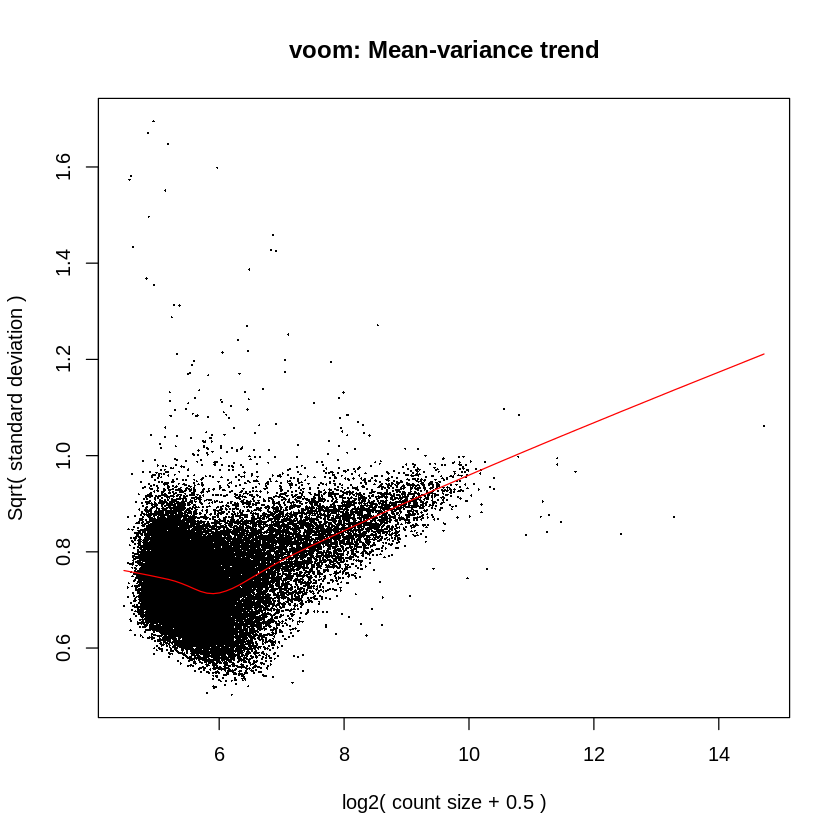

In [19]:
y <- voom(dge, design, plot=TRUE)

Correct batch effects by accounting for donors and TSS Enrichment scores.

In [20]:
y.batch.corrected <- removeBatchEffect(y, batch=donors, covariates=tss.score, design=design)

In [21]:
write.csv(y.batch.corrected, "~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_counts_normalized.csv")

### Visualize Normalized Counts

In [22]:
pca <- prcomp(t(y.batch.corrected))

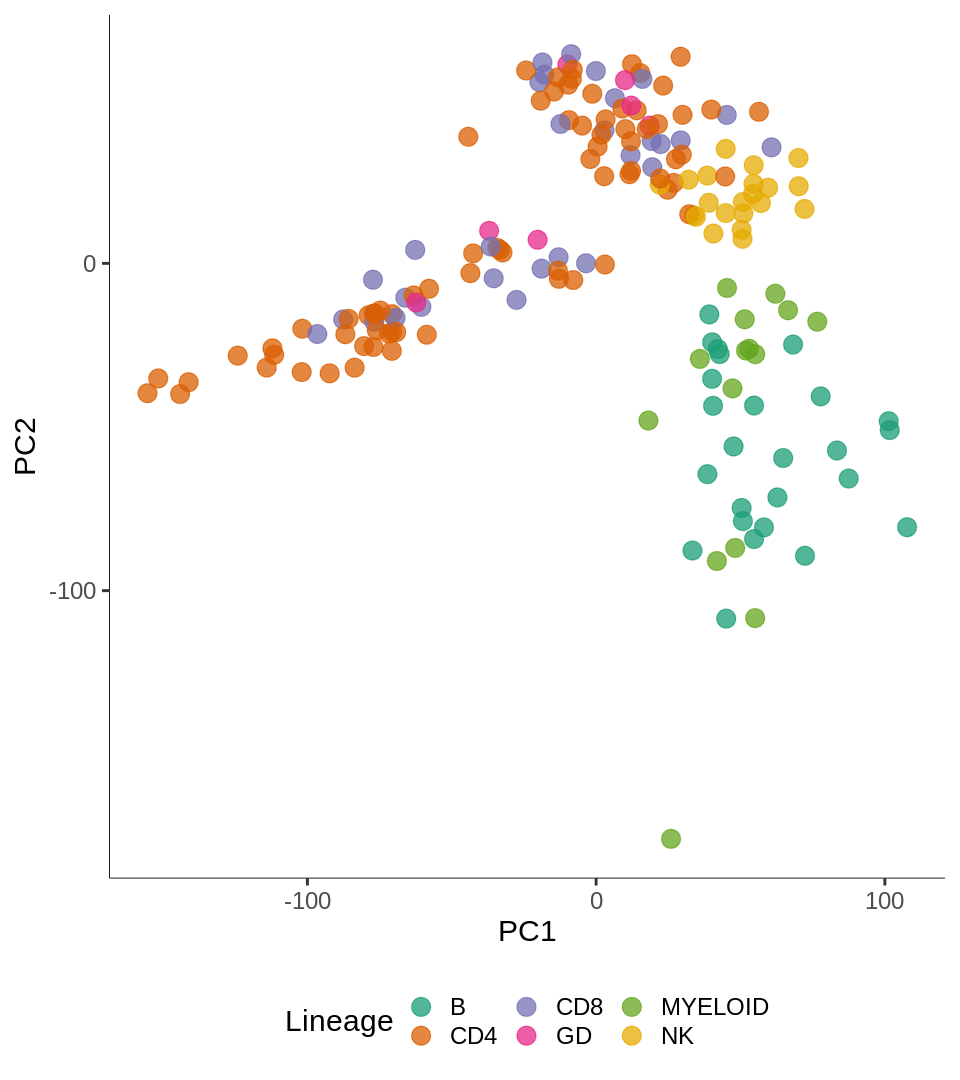

In [23]:
options(repr.plot.width=8, repr.plot.height=9)

merge(pca$x, sample.info, by.x=0, by.y="Run") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_peak_count_pca.svg", width=8, height=9)

In [24]:
set.seed(89734987)
tsne.res <- Rtsne(t(y.batch.corrected[,stimulated == "Baseline"]), num_threads=4, perplexity=10)

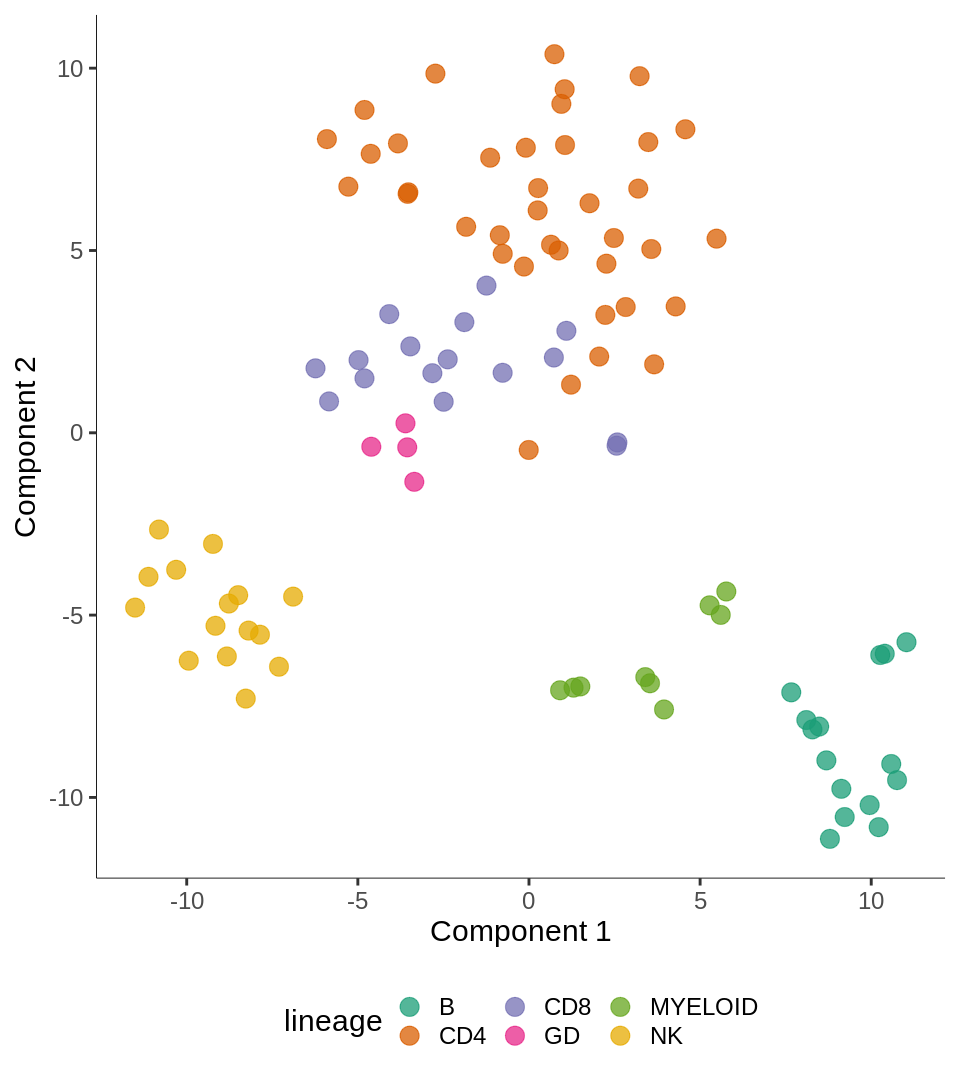

In [25]:
options(repr.plot.width=8, repr.plot.height=9)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Run=colnames(y.batch.corrected[,stimulated == "Baseline"])) %>%
    merge(., sample.info, by="Run") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_peak_count_tsne.svg", width=8, height=9)

### Limma

Use `limma` to fit a linear model consisting of the biological `groups`.

In [26]:
fit <- lmFit(y.batch.corrected, design)

#### DA Peaks between Stimulated and Unstimulated Cells

Identify all cell types where both the baseline and stimulated conditions are present.

In [27]:
cell.type.conditions <- cbind(cell.type, stimulated) %>%
    as.data.frame() %>%
    dplyr::select(Cell.Type=1, Stimulated=2) %>%
    dplyr::group_by(Cell.Type, Stimulated) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(Stimulated, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [28]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [29]:
da.peaks <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Cell.Type, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Accessible Peaks

Calculate differentially accessible peaks. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

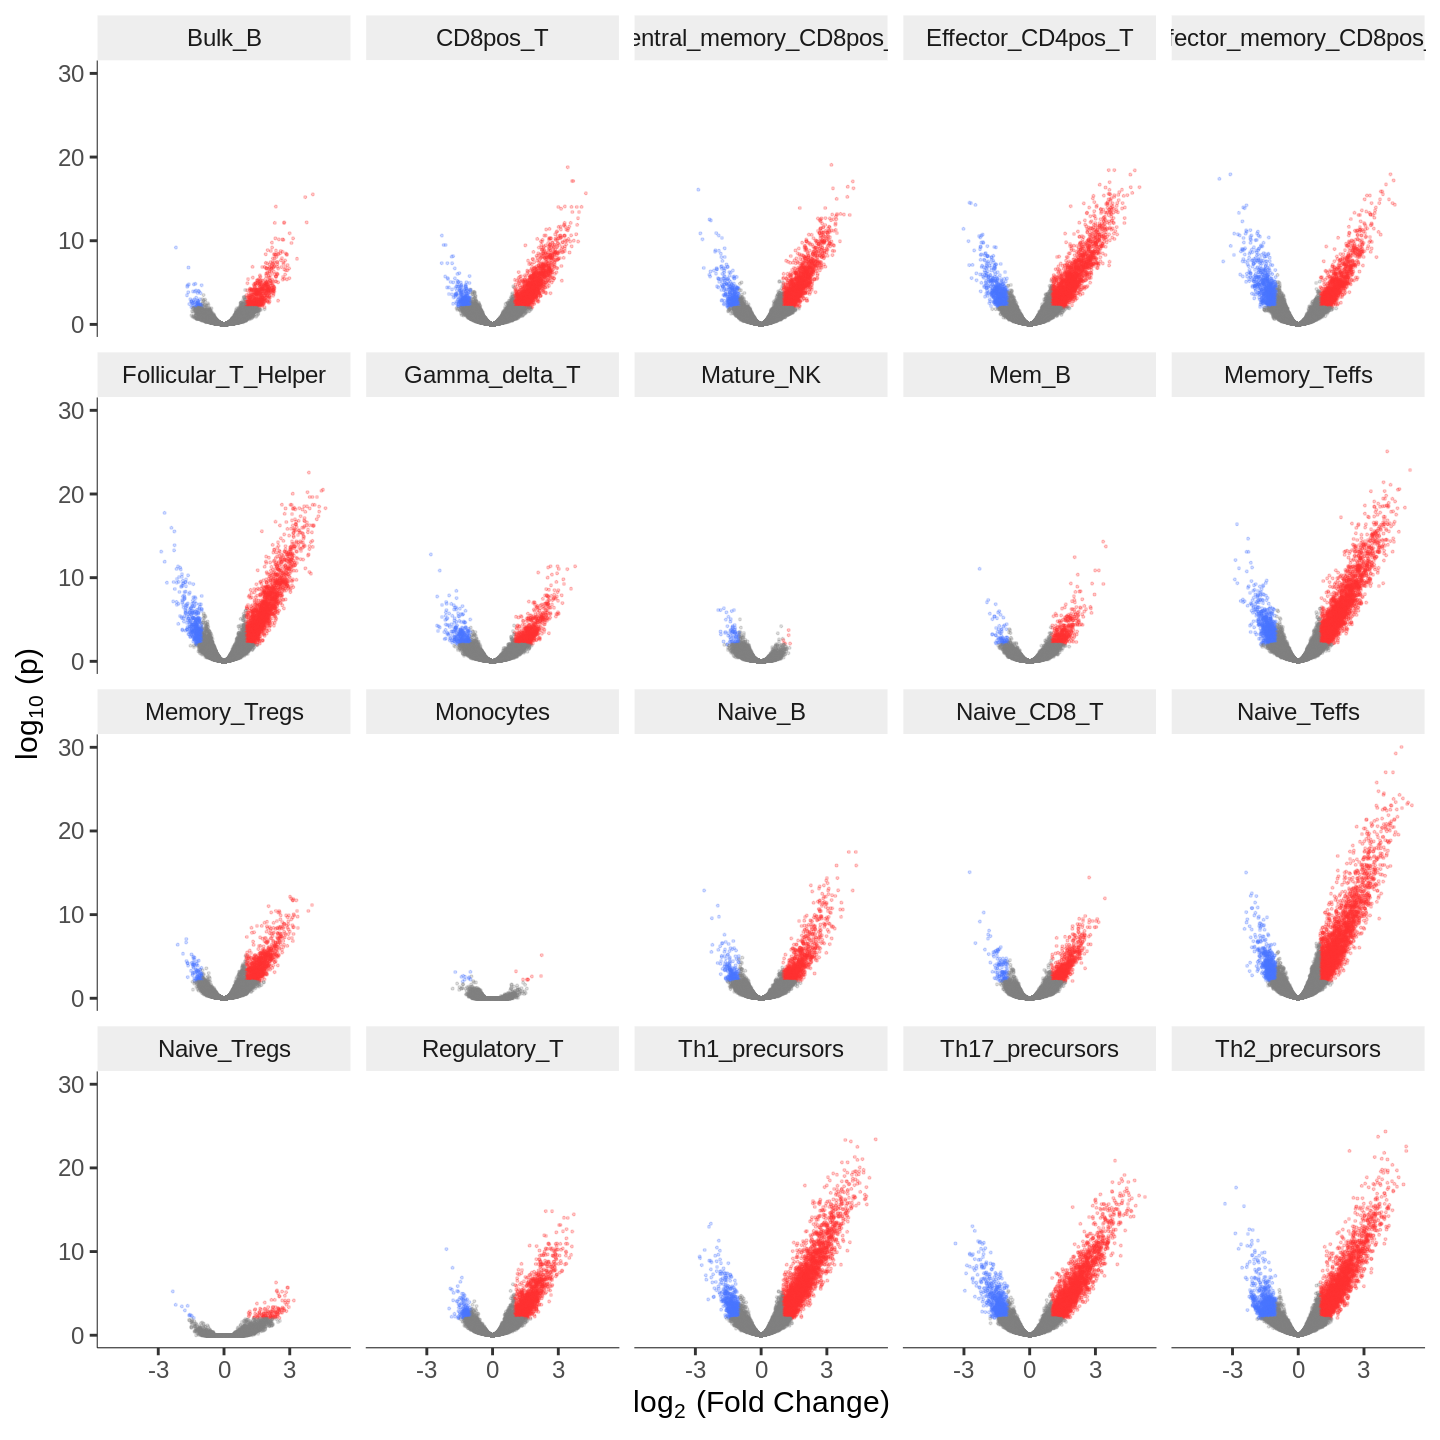

In [30]:
options(repr.plot.width=12, repr.plot.height=12)

abs.max.log.fc <- max(abs(da.peaks$logFC))

da.peaks %>%
    dplyr::mutate(log.adj.P.Val=-log10(adj.P.Val)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.adj.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Cell.Type)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/da_peaks_volcano_plots.png", width=12, height=12)

In [31]:
da.peak.set <- da.peaks %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(da.peak.set, "~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/da_peak_set.csv")

There are 10140 total peaks that are DA peaks in at least one condition.

In [32]:
length(unique(da.peak.set$Peak.ID))

[1] 10140

Some peaks will likely be differentially accessible when stimulated in various cell types.

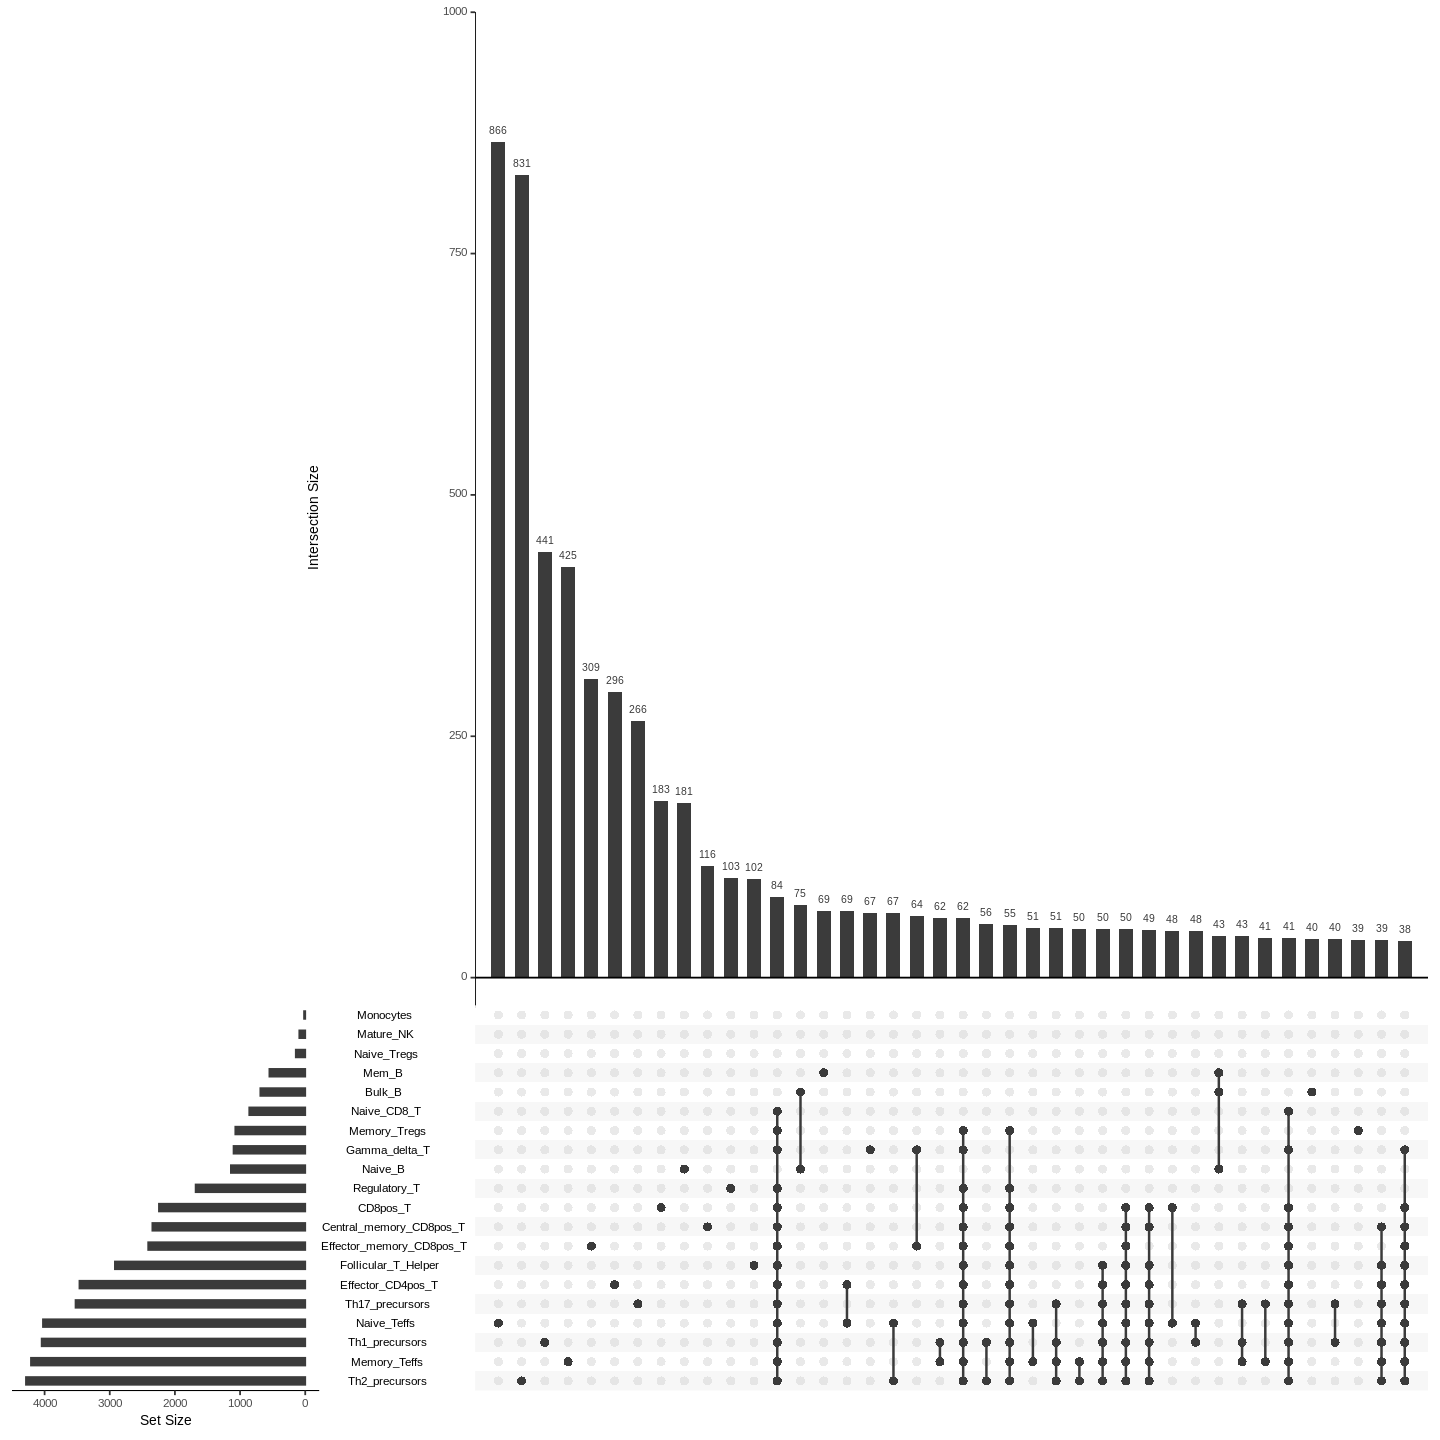

In [33]:
options(repr.plot.width=12, repr.plot.height=12)

peak.sets <- split(da.peak.set$Peak.ID, da.peak.set$Cell.Type)
upset(fromList(peak.sets), order.by="freq", nsets=20)

In [34]:
calderon.peaks <- fread("03_Functional_Interpretation/data/41588_2019_505_MOESM6_ESM", header=T)

In [35]:
calderon.peaks[, contrast.1 := sapply(strsplit(contrast, "-"), function(x) { x[1] })]
calderon.peaks[, contrast.2 := substr(contrast.1, start=1, stop=nchar(contrast.1) - 2)]

In [36]:
head(calderon.peaks)

logFC,AveExpr,t,P.Value,adj.P.Val,B,peak_id,contrast,contrast.1,contrast.2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
-1.588574,3.3247484,-6.191998,4.143337e-09,5.706523e-06,10.493297,chr1_101414421_101416252,Bulk_B_S-Bulk_B_U,Bulk_B_S,Bulk_B
2.756835,0.6313412,6.256419,2.960920e-09,4.359877e-06,10.611203,chr1_101553654_101554433,Bulk_B_S-Bulk_B_U,Bulk_B_S,Bulk_B
1.924191,1.5682451,5.366348,2.534916e-07,1.650887e-04,6.625015,chr1_101875468_101877095,Bulk_B_S-Bulk_B_U,Bulk_B_S,Bulk_B
2.668101,-0.5097610,5.665378,5.963462e-08,5.036673e-05,7.831728,chr1_105307605_105308001,Bulk_B_S-Bulk_B_U,Bulk_B_S,Bulk_B
-3.099729,-1.1869313,-4.608955,7.798513e-06,2.662072e-03,2.921995,chr1_108073851_108074235,Bulk_B_S-Bulk_B_U,Bulk_B_S,Bulk_B
1.297943,3.4413420,4.349563,2.317296e-05,6.296819e-03,2.268438,chr1_108475984_108478550,Bulk_B_S-Bulk_B_U,Bulk_B_S,Bulk_B


In [37]:
table(calderon.peaks$contrast.2)


                  Bulk_B                 CD8pos_T  Central_memory_CD8pos_T 
                    2760                    10449                    14802 
       Effector_CD4pos_T Effector_memory_CD8pos_T      Follicular_T_Helper 
                   22852                    16060                    22499 
           Gamma_delta_T                Mature_NK                    Mem_B 
                    5540                      578                     2230 
            Memory_Teffs             Memory_Tregs                Monocytes 
                   31312                     6082                      115 
                 Naive_B              Naive_CD8_T              Naive_Teffs 
                    4759                     3282                    20617 
             Naive_Tregs             Regulatory_T           Th1_precursors 
                     117                     8733                    28080 
         Th17_precursors           Th2_precursors 
                   23475            

In [38]:
table(da.peak.set$Cell.Type)


                  Bulk_B                 CD8pos_T  Central_memory_CD8pos_T 
                     689                     2245                     2346 
       Effector_CD4pos_T Effector_memory_CD8pos_T      Follicular_T_Helper 
                    3465                     2410                     2921 
           Gamma_delta_T                Mature_NK                    Mem_B 
                    1100                       91                      550 
            Memory_Teffs             Memory_Tregs                Monocytes 
                    4209                     1073                       18 
                 Naive_B              Naive_CD8_T              Naive_Teffs 
                    1141                      859                     4025 
             Naive_Tregs             Regulatory_T           Th1_precursors 
                     145                     1682                     4045 
         Th17_precursors           Th2_precursors 
                    3525            